# Credal Sets — Analysis & Plots

This notebook visualises the trained credal sets (per dataset) and compares the credal mixture samples against true data and individual prior models.

**Assumptions**
- Outputs are under `out_fm_solver/`.
- `manifest.txt` lists checkpoints and `.npy` sample paths (as produced by `run_all.sh`).
- `credal_weights.json` is produced by `credal_run.sh`/`opt_credal_kl.py`.



In [1]:

import os, json, math, numpy as np, matplotlib.pyplot as plt
from collections import defaultdict

OUTDIR = "out_fm_solver"
MANIFEST = os.path.join(OUTDIR, "manifest.txt")
WEIGHTS_JSON = os.path.join(OUTDIR, "credal_weights.json")

assert os.path.exists(MANIFEST), f"Missing manifest at {MANIFEST}"
assert os.path.exists(WEIGHTS_JSON), f"Missing weights at {WEIGHTS_JSON}"

with open(WEIGHTS_JSON, "r") as f:
    WEIGHTS = json.load(f)

# Parse manifest into: by_dataset[dataset][prior] -> samples_path
by_dataset = defaultdict(dict)
with open(MANIFEST, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        d, p, ckpt, samp = line.split(",")
        by_dataset[d][p] = samp

datasets = sorted(by_dataset.keys())
datasets


['eight_ring', 'moons', 'spirals']

## Helper functions

In [2]:

def load_samples_map(sample_map):
    data = {}
    for prior, path in sample_map.items():
        assert os.path.exists(path), f"Missing samples: {path}"
        arr = np.load(path)  # shape [N,2]
        data[prior] = arr
    return data

def sample_mixture(prior2samples, priors, weights, n):
    # Multinomial component draw, then per-component row selection
    weights = np.asarray(weights, dtype=np.float64)
    weights = weights / weights.sum()
    counts = np.random.multinomial(n, weights)
    parts = []
    for prior, k in zip(priors, counts):
        if k == 0:
            continue
        arr = prior2samples[prior]
        idx = np.random.randint(0, arr.shape[0], size=k)
        parts.append(arr[idx])
    if not parts:
        return np.zeros((0, 2), dtype=np.float32)
    return np.concatenate(parts, axis=0)

def plot_scatter(ax, X, title, s=3, alpha=0.6):
    ax.scatter(X[:,0], X[:,1], s=s, alpha=alpha)
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_aspect("equal", adjustable="box")

def two_d_hist_kl(p_samps, q_samps, bins=100, eps=1e-9):
    # crude grid KL: KL(P||Q) where P and Q are 2D histograms normalized to probabilities
    xmin = min(p_samps[:,0].min(), q_samps[:,0].min())
    xmax = max(p_samps[:,0].max(), q_samps[:,0].max())
    ymin = min(p_samps[:,1].min(), q_samps[:,1].min())
    ymax = max(p_samps[:,1].max(), q_samps[:,1].max())

    Hp, xedges, yedges = np.histogram2d(p_samps[:,0], p_samps[:,1], bins=bins, range=[[xmin, xmax],[ymin, ymax]])
    Hq, _, _            = np.histogram2d(q_samps[:,0], q_samps[:,1], bins=[xedges, yedges])

    P = Hp.astype(np.float64); Q = Hq.astype(np.float64)
    P = P / (P.sum() + eps)
    Q = Q / (Q.sum() + eps)

    ratio = (P + eps) / (Q + eps)
    kl = (P * np.log(ratio)).sum()
    return kl

def rbf_mmd(X, Y, gammas=(0.5, 1.0, 2.0)):
    # unbiased MMD^2 with a few RBF bandwidths; X,Y: [N,2]
    def k(a, b, gamma):
        # compute pairwise squared distances in a vectorized way
        aa = np.sum(a*a, axis=1, keepdims=True)
        bb = np.sum(b*b, axis=1, keepdims=True)
        d2 = aa + bb.T - 2*np.dot(a, b.T)
        return np.exp(-gamma * d2)
    m = min(len(X), len(Y), 2000)  # cap for speed
    Xs = X[np.random.choice(len(X), m, replace=False)]
    Ys = Y[np.random.choice(len(Y), m, replace=False)]
    mmd = 0.0
    for g in gammas:
        Kxx = k(Xs, Xs, g)
        Kyy = k(Ys, Ys, g)
        Kxy = k(Xs, Ys, g)
        # unbiased estimates (diagonal removed)
        np.fill_diagonal(Kxx, 0.0)
        np.fill_diagonal(Kyy, 0.0)
        mmd += Kxx.sum()/(m*(m-1)) + Kyy.sum()/(m*(m-1)) - 2*Kxy.mean()
    return mmd / len(gammas)


## Visualise weights

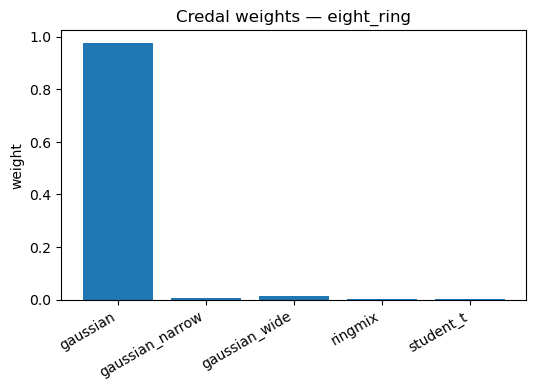

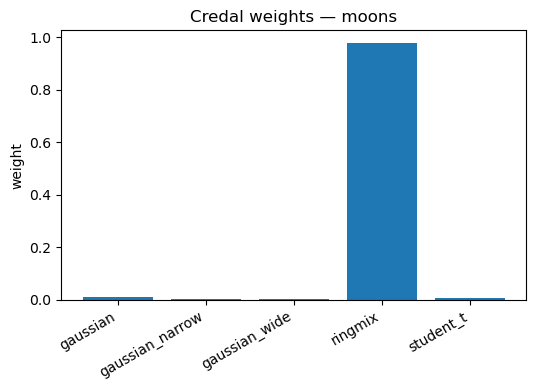

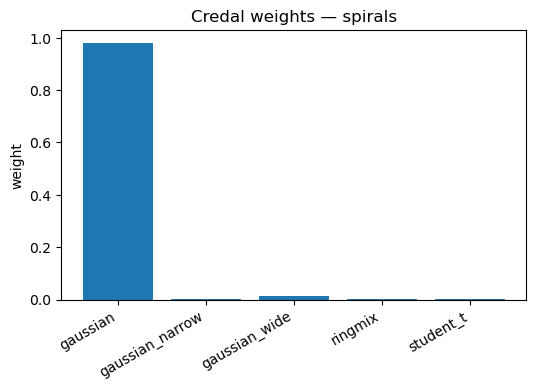

In [3]:

import matplotlib.pyplot as plt

for d in datasets:
    priors = WEIGHTS[d]["priors"]
    w = np.array(WEIGHTS[d]["weights"], dtype=float)
    fig, ax = plt.subplots(figsize=(6,3.5))
    ax.bar(range(len(w)), w)
    ax.set_xticks(range(len(priors)))
    ax.set_xticklabels(priors, rotation=30, ha='right')
    ax.set_title(f"Credal weights — {d}")
    ax.set_ylabel("weight")
    plt.show()


## Per-dataset: scatter plots (true vs priors vs mixture)
This uses 10k points for clarity. Increase if needed.

=== Dataset: eight_ring ===


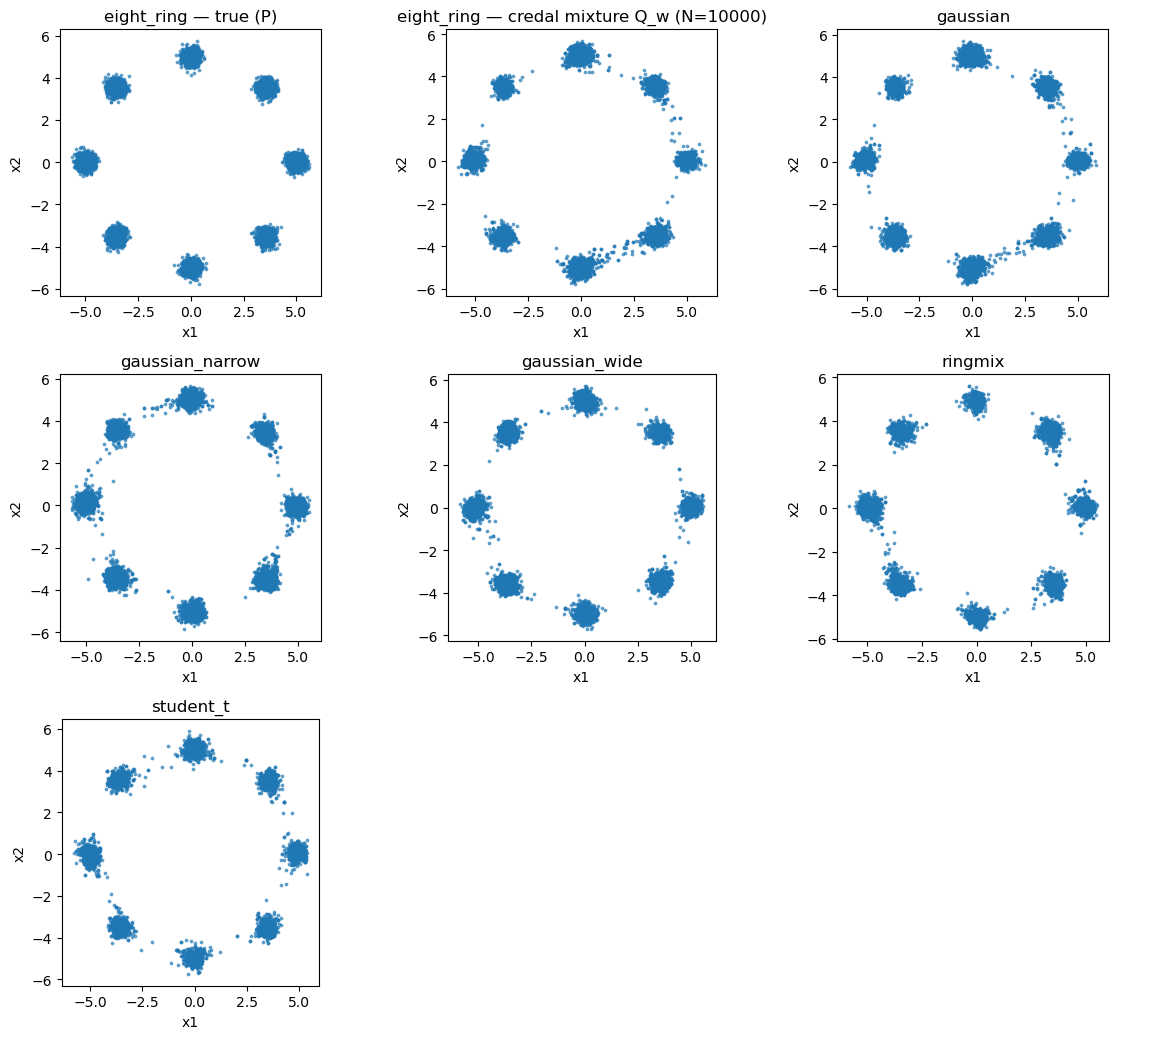

=== Dataset: moons ===


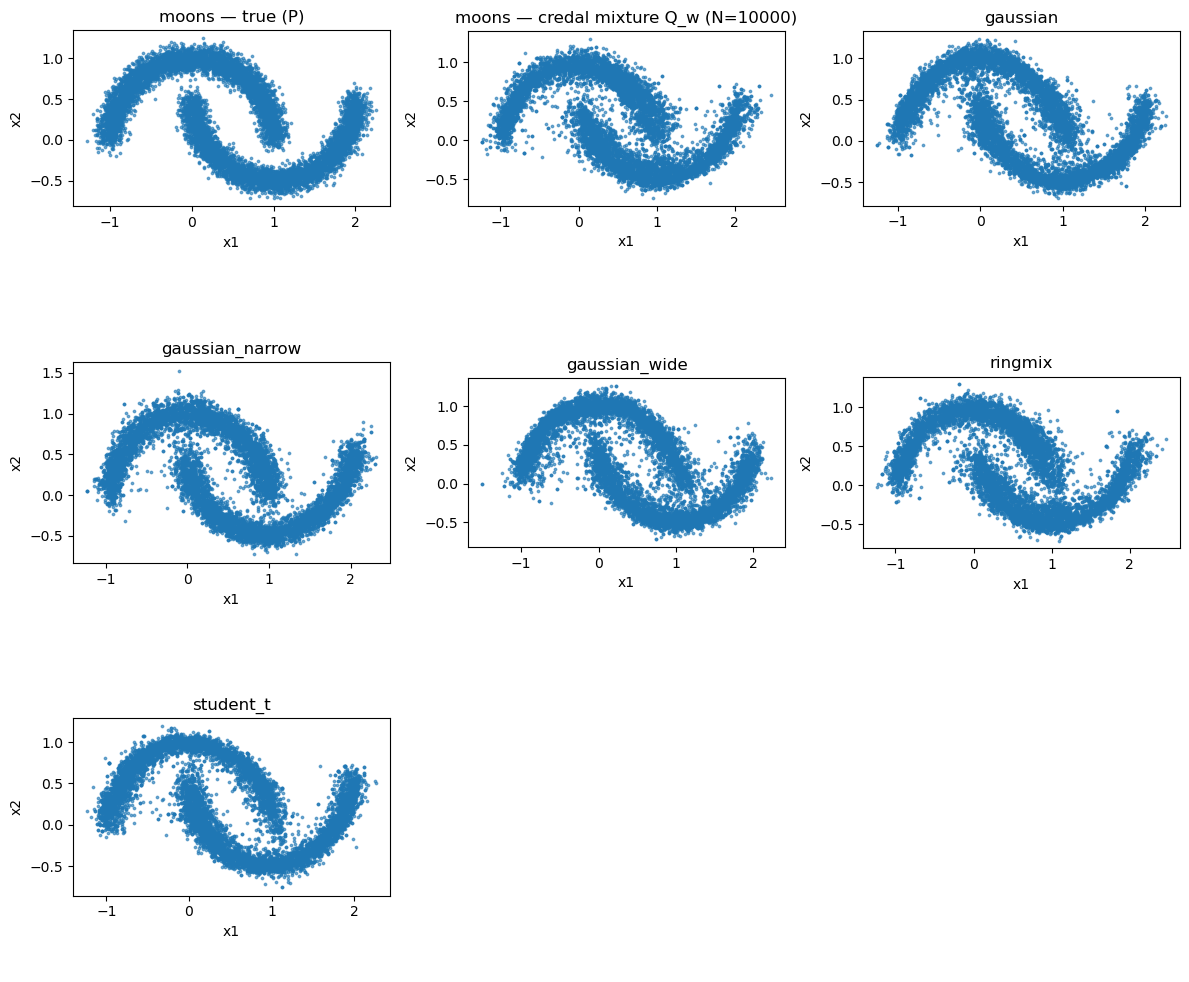

=== Dataset: spirals ===


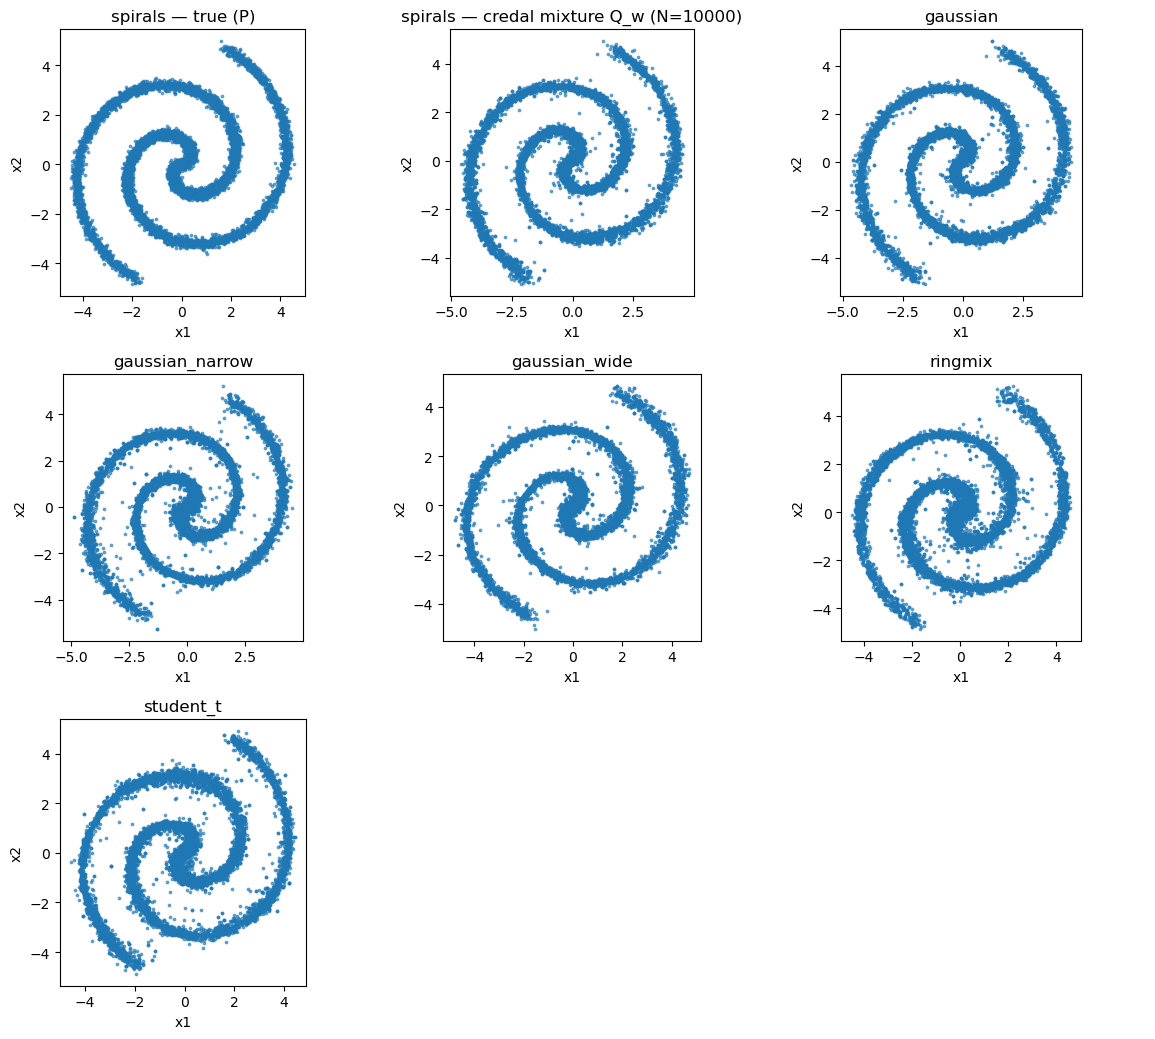

In [4]:

from train_flow import make_dataset

N_SHOW = 10000  # samples shown per plot
for d in datasets:
    print("=== Dataset:", d, "===")
    # load prior sample arrays
    p2s = by_dataset[d]
    data_map = load_samples_map(p2s)
    # load target data (fresh samples) to compare
    P = make_dataset(d)
    X_true = P.sample(N_SHOW).cpu().numpy()

    priors = WEIGHTS[d]["priors"]
    weights = WEIGHTS[d]["weights"]
    X_mix = sample_mixture(data_map, priors, weights, N_SHOW)

    # grid of scatters: true, mixture, each prior
    ncols = 3
    nrows = math.ceil((2 + len(priors)) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows))
    axes = axes.reshape(-1)

    plot_scatter(axes[0], X_true, f"{d} — true (P)")
    plot_scatter(axes[1], X_mix,  f"{d} — credal mixture Q_w (N={len(X_mix)})")

    for i, prior in enumerate(priors, start=2):
        Xk = data_map[prior]
        idx = np.random.randint(0, Xk.shape[0], size=N_SHOW)
        plot_scatter(axes[i], Xk[idx], f"{prior}")
    for j in range(2+len(priors), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


## Quantitative diagnostics
We report a crude 2D-histogram KL(P‖Q) and an RBF-MMD between the true data and the credal mixture samples.

In [5]:

for d in datasets:
    p2s = by_dataset[d]
    data_map = load_samples_map(p2s)
    P = make_dataset(d)
    X_true = P.sample(50000).cpu().numpy()
    priors = WEIGHTS[d]["priors"]
    weights = WEIGHTS[d]["weights"]
    X_mix = sample_mixture(data_map, priors, weights, 50000)

    kl_grid = two_d_hist_kl(X_true, X_mix, bins=150)
    mmd = rbf_mmd(X_true, X_mix, gammas=(0.5, 1.0, 2.0))

    print(f"{d:12s}  KL_grid≈{kl_grid:.4f}   MMD≈{mmd:.4f}")


eight_ring    KL_grid≈0.4637   MMD≈0.0017
moons         KL_grid≈2.0283   MMD≈0.0039
spirals       KL_grid≈1.2881   MMD≈0.0011



=== eight_ring: Bootstrap (B=200, n=20000) ===
Gaps are (prior - credal); >0 means credal is better.
prior           ΔKL mean           [2.5%,97.5%]    ΔMMD mean           [2.5%,97.5%]
gaussian          0.0246  [-0.0260, 0.0834]         0.0000  [-0.0020, 0.0021]  
gaussian_narrow     -0.0663  [-0.1214,-0.0054]        -0.0005  [-0.0023, 0.0013]  
gaussian_wide     -0.0734  [-0.1301,-0.0147]        -0.0005  [-0.0026, 0.0013]  
ringmix           0.2331  [ 0.1621, 0.3049] *       0.0003  [-0.0020, 0.0031]  
student_t         0.0712  [ 0.0114, 0.1396] *      -0.0007  [-0.0029, 0.0011]  

Win rate (credal best among all priors):
KL_grid: 0/200 = 0.00%
MMD    : 17/200 = 8.50%


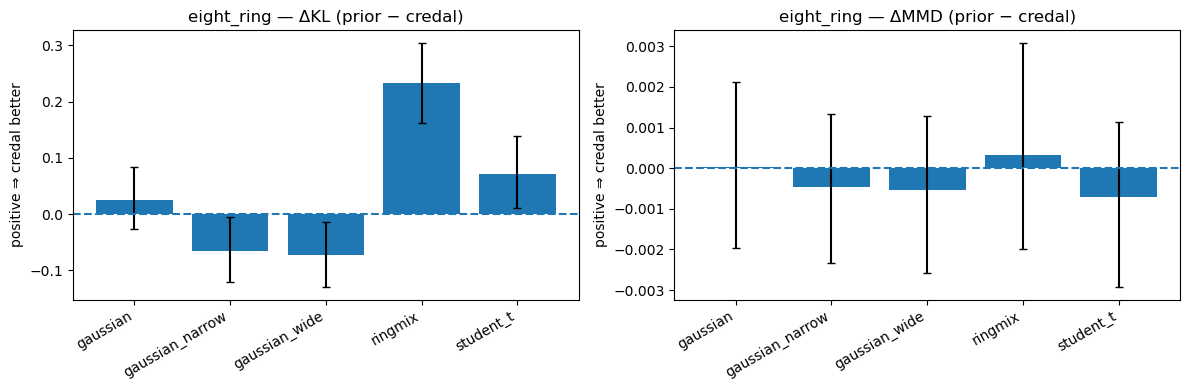


=== moons: Bootstrap (B=200, n=20000) ===
Gaps are (prior - credal); >0 means credal is better.
prior           ΔKL mean           [2.5%,97.5%]    ΔMMD mean           [2.5%,97.5%]
gaussian         -0.2295  [-0.3724,-0.0898]        -0.0031  [-0.0063,-0.0005]  
gaussian_narrow     -0.5462  [-0.7064,-0.3454]        -0.0033  [-0.0063,-0.0006]  
gaussian_wide     -0.4104  [-0.5744,-0.2013]        -0.0038  [-0.0071,-0.0011]  
ringmix           0.0782  [-0.0598, 0.2473]         0.0002  [-0.0034, 0.0040]  
student_t        -0.2602  [-0.4738, 0.0156]        -0.0031  [-0.0063,-0.0003]  

Win rate (credal best among all priors):
KL_grid: 0/200 = 0.00%
MMD    : 0/200 = 0.00%


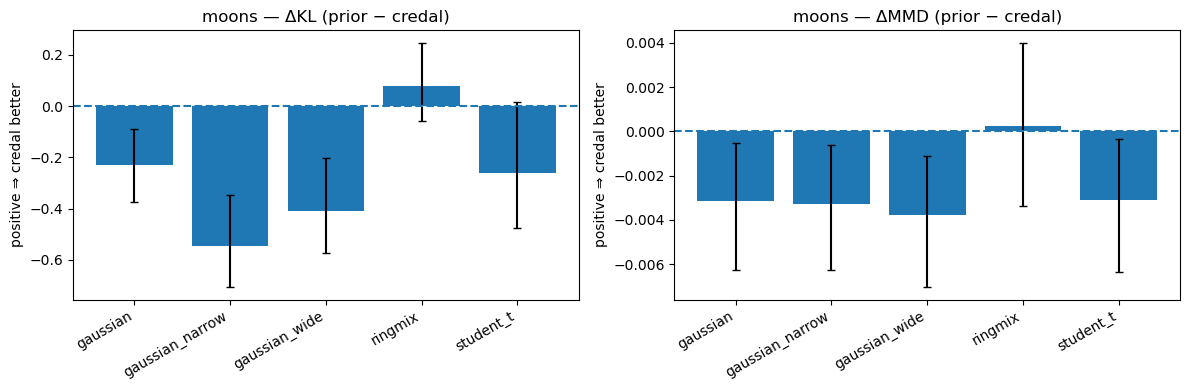


=== spirals: Bootstrap (B=200, n=20000) ===
Gaps are (prior - credal); >0 means credal is better.
prior           ΔKL mean           [2.5%,97.5%]    ΔMMD mean           [2.5%,97.5%]
gaussian          0.0519  [-0.0523, 0.1555]         0.0001  [-0.0010, 0.0012]  
gaussian_narrow     -0.1312  [-0.2412,-0.0279]         0.0004  [-0.0009, 0.0022]  
gaussian_wide      0.1808  [ 0.0669, 0.2957] *       0.0002  [-0.0010, 0.0015]  
ringmix          -0.0386  [-0.1676, 0.0807]         0.0008  [-0.0006, 0.0023]  
student_t         0.3242  [ 0.2145, 0.4393] *       0.0008  [-0.0002, 0.0022]  

Win rate (credal best among all priors):
KL_grid: 1/200 = 0.50%
MMD    : 72/200 = 36.00%


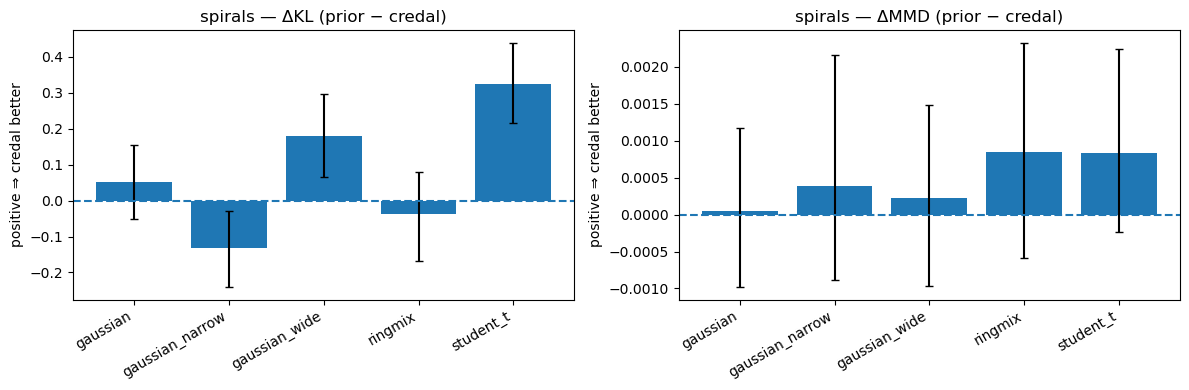

In [7]:
# === Bootstrap proof: credal vs each prior (significance) ===
# For each dataset, we run B bootstrap rounds.
# In each round we resample true data and model samples, compute KL_grid & MMD,
# and record (prior - credal) differences. We then report:
#  - mean gap and 95% CI for each prior,
#  - the % of rounds where credal beats ALL priors (win rate).

import numpy as np
import matplotlib.pyplot as plt

def bootstrap_credal_superiority(
    d, B=200, n=20000, bins=120, gammas=(0.5,1.0,2.0), seed=123
):
    rng = np.random.default_rng(seed)

    # Load data sources
    p2s = by_dataset[d]
    data_map = load_samples_map(p2s)
    P = make_dataset(d)

    priors = WEIGHTS[d]["priors"]
    weights = np.array(WEIGHTS[d]["weights"], float)

    # Storage: per prior, arrays of gaps (prior - credal)
    kl_gaps = {p: np.zeros(B, dtype=float) for p in priors}
    mmd_gaps = {p: np.zeros(B, dtype=float) for p in priors}

    credal_better_kl = 0
    credal_better_mmd = 0

    for b in range(B):
        # Fresh true samples each round
        X_true = P.sample(n).cpu().numpy()
        # Credal mixture samples
        X_mix = sample_mixture(data_map, priors, weights, n)
        kl_mix = two_d_hist_kl(X_true, X_mix, bins=bins)
        mmd_mix = rbf_mmd(X_true, X_mix, gammas=gammas)

        # Track if credal beats ALL priors this round
        all_kl = []
        all_mmd = []

        for p in priors:
            Xp = data_map[p]
            idx = rng.integers(0, Xp.shape[0], size=n)
            Xp = Xp[idx]
            kl_p = two_d_hist_kl(X_true, Xp, bins=bins)
            mmd_p = rbf_mmd(X_true, Xp, gammas=gammas)

            kl_gaps[p][b] = kl_p - kl_mix
            mmd_gaps[p][b] = mmd_p - mmd_mix

            all_kl.append(kl_p)
            all_mmd.append(mmd_p)

        if kl_mix < np.min(all_kl):  # lower is better
            credal_better_kl += 1
        if mmd_mix < np.min(all_mmd):
            credal_better_mmd += 1

    # Summaries
    def ci95(x):
        lo, hi = np.percentile(x, [2.5, 97.5])
        return np.mean(x), lo, hi

    print(f"\n=== {d}: Bootstrap (B={B}, n={n}) ===")
    print("Gaps are (prior - credal); >0 means credal is better.")
    rows = []
    for p in priors:
        m_kl, lo_kl, hi_kl = ci95(kl_gaps[p])
        m_md, lo_md, hi_md = ci95(mmd_gaps[p])
        sig_kl = " *" if lo_kl > 0 else ""   # CI entirely > 0
        sig_md = " *" if lo_md > 0 else ""
        rows.append((p, m_kl, lo_kl, hi_kl, m_md, lo_md, hi_md, sig_kl, sig_md))

    # Pretty print table
    print(f"{'prior':12s}  {'ΔKL mean':>10s}  {'[2.5%,97.5%]':>21s}   {'ΔMMD mean':>10s}  {'[2.5%,97.5%]':>21s}")
    for p, mkl, lkl, hkl, mmd, lmd, hmd, s1, s2 in rows:
        print(f"{p:12s}  {mkl:10.4f}  [{lkl:7.4f},{hkl:7.4f}]{s1:2s}   {mmd:10.4f}  [{lmd:7.4f},{hmd:7.4f}]{s2:2s}")

    # Global win rates (credal best vs all priors per round)
    print(f"\nWin rate (credal best among all priors):")
    print(f"KL_grid: {credal_better_kl}/{B} = {credal_better_kl/B:.2%}")
    print(f"MMD    : {credal_better_mmd}/{B} = {credal_better_mmd/B:.2%}")

    # Bar + CI plot for visual proof
    labels = [r[0] for r in rows]
    mean_kl = np.array([r[1] for r in rows])
    lo_kl   = np.array([r[2] for r in rows])
    hi_kl   = np.array([r[3] for r in rows])

    mean_md = np.array([r[4] for r in rows])
    lo_md   = np.array([r[5] for r in rows])
    hi_md   = np.array([r[6] for r in rows])

    x = np.arange(len(labels))
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].bar(x, mean_kl, yerr=[mean_kl - lo_kl, hi_kl - mean_kl], capsize=3)
    axs[0].axhline(0.0, linestyle='--')
    axs[0].set_xticks(x); axs[0].set_xticklabels(labels, rotation=30, ha='right')
    axs[0].set_title(f"{d} — ΔKL (prior − credal)"); axs[0].set_ylabel("positive ⇒ credal better")

    axs[1].bar(x, mean_md, yerr=[mean_md - lo_md, hi_md - mean_md], capsize=3)
    axs[1].axhline(0.0, linestyle='--')
    axs[1].set_xticks(x); axs[1].set_xticklabels(labels, rotation=30, ha='right')
    axs[1].set_title(f"{d} — ΔMMD (prior − credal)"); axs[1].set_ylabel("positive ⇒ credal better")

    plt.tight_layout()
    plt.show()

# Run for all datasets
for d in datasets:
    bootstrap_credal_superiority(d, B=200, n=20000, bins=120, gammas=(0.5,1.0,2.0), seed=42)


In [8]:
import numpy as np

def make_hist2d(X, xedges, yedges, eps=1e-12):
    H, _, _ = np.histogram2d(X[:,0], X[:,1], bins=[xedges, yedges])
    H = H.astype(np.float64)
    H = H / (H.sum() + eps)
    return H + eps  # smoothing to avoid zeros

def build_common_grid(P_samps, Q_list, bins=150):
    xmin = min([P_samps[:,0].min()] + [Q[:,0].min() for Q in Q_list])
    xmax = max([P_samps[:,0].max()] + [Q[:,0].max() for Q in Q_list])
    ymin = min([P_samps[:,1].min()] + [Q[:,1].min() for Q in Q_list])
    ymax = max([P_samps[:,1].max()] + [Q[:,1].max() for Q in Q_list])
    xedges = np.linspace(xmin, xmax, bins+1)
    yedges = np.linspace(ymin, ymax, bins+1)
    return xedges, yedges

def solve_weights_grid_kl(P_hist, Q_hists, iters=3000, lr=0.3, lam_entropy=0.0):
    K = len(Q_hists)
    alpha = np.zeros(K)                       # logits
    for t in range(iters):
        w = np.exp(alpha - alpha.max()); w /= w.sum()
        mix = np.tensordot(w, Q_hists, axes=(0,0))  # sum_k w_k Q_k[b]
        # objective: L(w)=sum_b P_b * (-log mix_b)  + lam * sum_k w_k log w_k  (entropy reg)
        # grad wrt w_j: - sum_b P_b * Q_j[b]/mix_b  + lam*(1+log w_j)
        grad_w = -np.array([np.sum(P_hist * (Q_hists[j] / mix)) for j in range(K)]) \
                 + lam_entropy * (1.0 + np.log(np.clip(w,1e-12,None)))
        # convert to grad wrt alpha (softmax Jacobian-vector product)
        gw_dot_w = np.dot(grad_w, w)
        grad_alpha = w * (grad_w - gw_dot_w)
        alpha -= lr * grad_alpha
        # optional mild lr decay
        if (t+1) % 500 == 0: lr *= 0.9
    w = np.exp(alpha - alpha.max()); w /= w.sum()
    return w
